In [12]:
import numpy as np
import bilby
from radio_likelihoods import EMPulsarLikelihood
import models
from functools import partial
import jax
models.set_backend("jax")

In [24]:
class Likelihood(bilby.Likelihood):
    def __init__(self, radio_data_path, fiducial_population_params, backend='jax', n_samples=5000):

        self.radio_likelihood = EMPulsarLikelihood(path=radio_data_path, backend=backend)
        self.n_samples = n_samples
        self.parameters = dict( mmin=None, mpop=None, mu1=None, mu2=None, sigma1=None, sigma2=None, frac1=None)
        self.fiducial_parameters = fiducial_population_params
        self.draw_proposal_pulsars()
        super().__init__(parameters = self.parameters)
        self.xp = models.xp
        
    def draw_proposal_pulsars(self):
        self.proposal_pulsars =  models.draw_fiducial_pulsar_samples(seed=1, **self.fiducial_parameters)
        self.proposal_radio_likelihoods = self.radio_likelihood.likelihood_per_event_per_sample(self.proposal_pulsars['mass'])
    
    def radio_log_likelihood(self, samples):
        return self.pulsar_object.log_likelihood(samples)
        
    @partial(jax.jit, static_argnums=(0,))
    def pulsar_log_likelihood(self, mass_weights):
        return self.xp.sum(self.xp.log(
            self.xp.mean(
                self.xp.exp(
                    self.xp.log(self.proposal_radio_likelihoods) + self.xp.log(mass_weights)), axis=-1)
        )
                               )
    
    @partial(jax.jit, static_argnums=(0,))
    def get_mass_weights(self, parameters):
        return models.get_pulsar_mass_weights(self.proposal_pulsars['mass'], self.proposal_pulsars['p_draw'], **parameters)
    #@partial(jax.jit, static_argnums=(0,))
    def log_likelihood(self):
        mass_weights =  self.get_mass_weights(self.parameters)
        llPulsars = self.pulsar_log_likelihood(mass_weights)
        return llPulsars

In [25]:
likelihood = Likelihood(radio_data_path='pulsars.h5',
                                     n_samples=5000, 
                                     fiducial_population_params={'mmin': 1, 'mmax': 3.2, 'mu': 1.35, 'sigma': 0.05, 'gaussian_frac': 0.4})

In [34]:
def conditional_mu_2(reference_parameters, mu1):
    return dict(minimum = mu1, maximum = reference_parameters['maximum'])

prior = bilby.core.prior.ConditionalPriorDict()
prior['mpop'] = bilby.core.prior.Uniform(minimum=1.8, maximum=3, name='mpop', latex_label=r'$m_{\rm pop}$', unit=None, boundary=None)
prior['mmin']=1
prior['frac1'] = bilby.core.prior.Uniform(minimum = 0, maximum = 1)
prior['mu1'] = bilby.core.prior.Uniform(minimum=1, maximum=2)
prior['sigma1'] = bilby.core.prior.Uniform(minimum = 0.05, maximum=1)
prior['sigma2'] = bilby.core.prior.Uniform(minimum = 0.05, maximum = 1)
prior['mu2'] = bilby.core.prior.ConditionalUniform(minimum = 1, maximum = 2.5, condition_func = conditional_mu_2)

result =  bilby.core.sampler.run_sampler(likelihood, prior, label = 'example', outdir = './example_outdir/', sampler = 'dynesty', use_ratio=False)

13:49 bilby INFO    : Running for label 'example', output will be saved to './example_outdir/'
13:49 bilby INFO    : Analysis priors:
13:49 bilby INFO    : mpop=Uniform(minimum=1.8, maximum=3, name='mpop', latex_label='$m_{\\rm pop}$', unit=None, boundary=None)
13:49 bilby INFO    : frac1=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
13:49 bilby INFO    : mu1=Uniform(minimum=1, maximum=2, name=None, latex_label=None, unit=None, boundary=None)
13:49 bilby INFO    : sigma1=Uniform(minimum=0.05, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
13:49 bilby INFO    : sigma2=Uniform(minimum=0.05, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
13:49 bilby INFO    : mu2=ConditionalUniform(condition_func='__main__.conditional_mu_2', name=None, latex_label=None, unit=None, boundary=None, minimum=1, maximum=2.5)
13:49 bilby INFO    : mmin=1
13:49 bilby INFO    : Analysis likelihood class: <class '__main__.Likelihood'>
13:4

6539it [04:04, 10.14it/s, bound:680 nc:  1 ncall:4.7e+05 eff:1.4% logz=23.74+/-0.12 dlogz:0.073>0.1]

13:54 bilby INFO    : Written checkpoint file ./example_outdir//example_resume.pickle


6539it [04:13, 14.74it/s, bound:680 nc:  1 ncall:4.8e+05 eff:1.5% logz=23.78+/-0.13 dlogz:0.000>0.1]

13:54 bilby INFO    : Rejection sampling nested samples to obtain 2125 posterior samples
13:54 bilby INFO    : Sampling time: 0:06:08.559926


13:54 bilby INFO    : Summary of results:
nsamples: 2125
ln_noise_evidence:    nan
ln_evidence: 23.783 +/-  0.154
ln_bayes_factor:    nan +/-  0.154



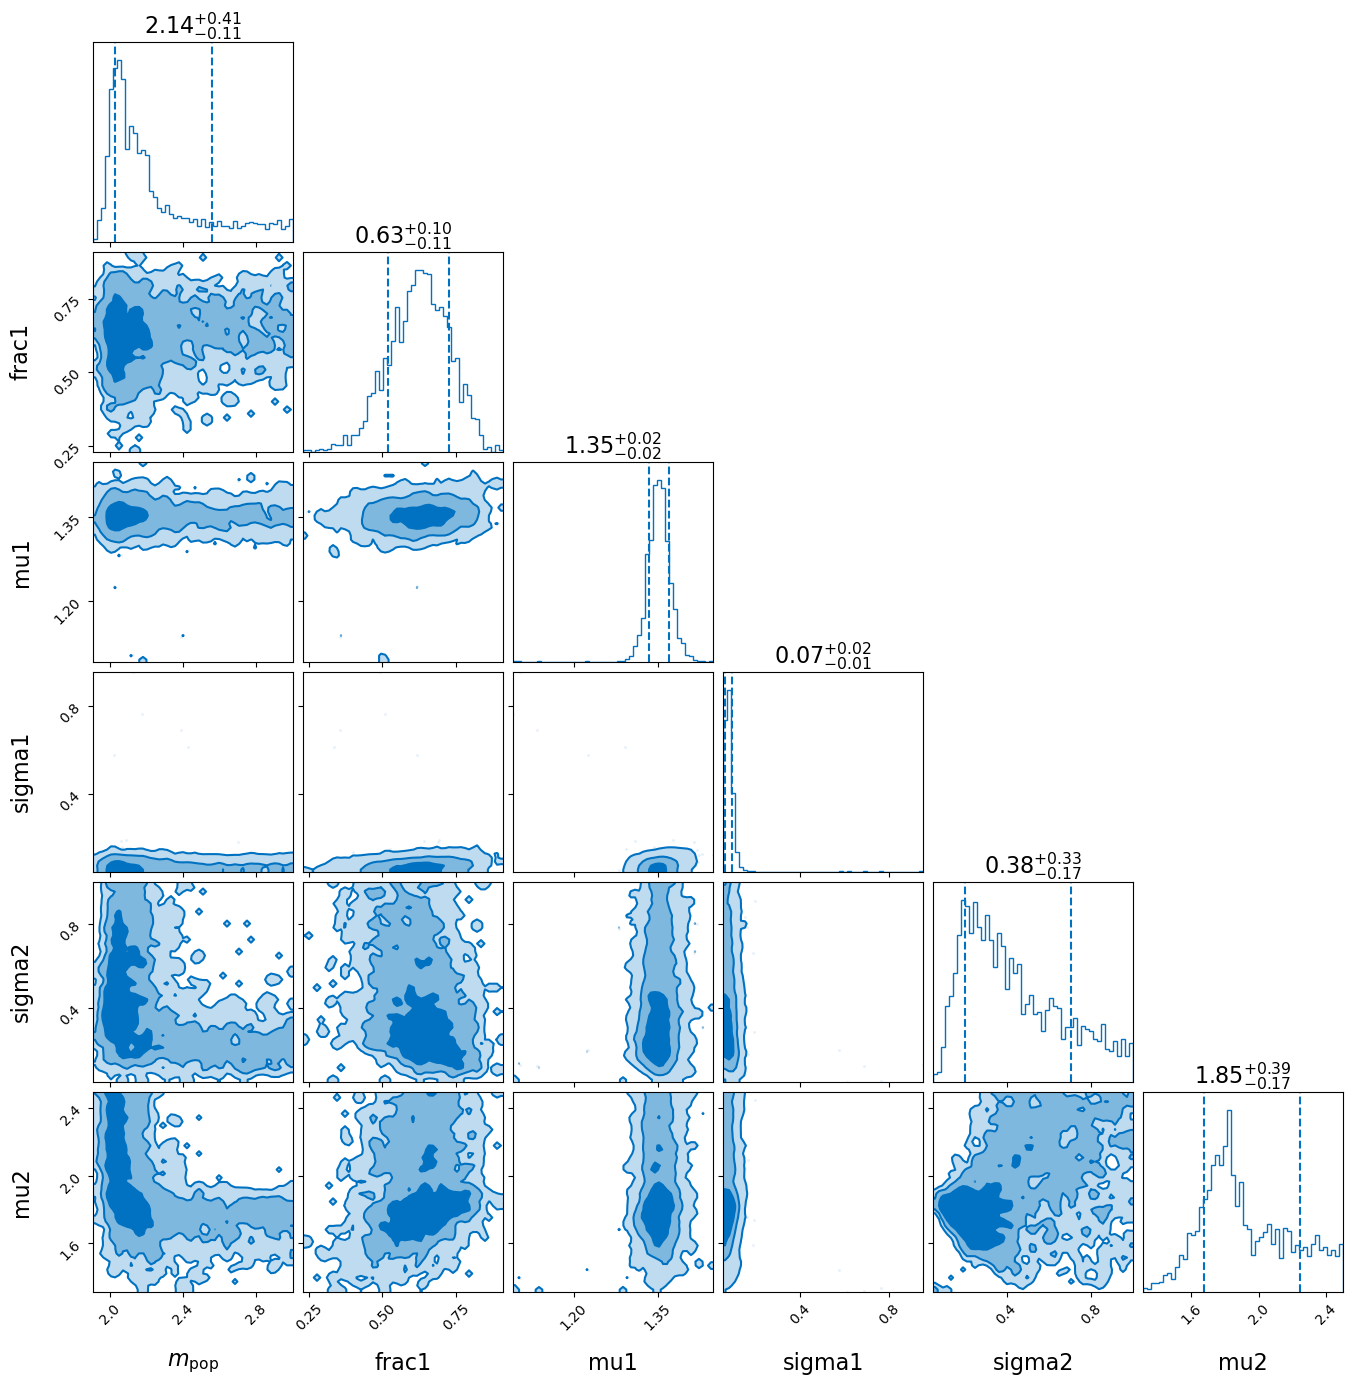

In [36]:
result.plot_corner()